# PosePrior Demo

This notebook contains code to convert `PosePrior` as implemented in "Learning to Estimate 3D Hand Pose from Single RGB Images" by Zimmerman et al. Their project is available at [https://github.com/lmb-freiburg/hand3d].

In [12]:
import os
import sys
import math

import torch
import torchvision
import torch.nn.functional as F
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

model_path = os.path.abspath(os.path.join('..'))
if model_path not in sys.path:
    sys.path.append(model_path)
    
from colorhandpose3d.model.HandSegNet import HandSegNet
from colorhandpose3d.model.PoseNet import PoseNet
from colorhandpose3d.model.PosePrior import PosePrior
from colorhandpose3d.model.ViewPoint import ViewPoint
from colorhandpose3d.utils.general import *
from colorhandpose3d.utils.transforms import flip_right_hand, get_rotation_matrix

## Initialize Models

`PosePrior` depends on the output of `HandSegNet`+`PoseNet`. First define the required models.

In [2]:
handsegnet = HandSegNet()
posenet = PoseNet()
poseprior = PosePrior()

handsegnet.load_state_dict(torch.load('/home/alex/dev/projects/colorhandpose3d-pytorch/saved/handsegnet.pth.tar'))
posenet.load_state_dict(torch.load('/home/alex/dev/projects/colorhandpose3d-pytorch/saved/posenet.pth.tar'))

## Import weights from Tensorflow model

The weights are saved in `pickle` format from the Tensorflow model.

In [3]:
file_name = '/home/alex/dev/projects/hand3d-master/weights/posenet3d-rhd-stb-slr-finetuned.pickle'
session = tf.Session()
exclude_var_list = list()

# read from pickle file
with open(file_name, 'rb') as fi:
    weight_dict = pickle.load(fi)
    weight_dict = {k: v for k, v in weight_dict.items() if not any([x in k for x in exclude_var_list])}
    
keys = [k for k, v in weight_dict.items() if 'PosePrior' in k]
keys.sort()

[print(k, weight_dict[k].shape) for k in keys]
    
for name, module in poseprior.named_children():
    key = 'PosePrior/{0}/'.format(name)
    if key + 'biases' in weight_dict:
        b = torch.tensor(weight_dict[key + 'biases'])
        w = torch.tensor(weight_dict[key + 'weights'])
        if len(w.shape) == 4:
            w = w.permute((3, 2, 0, 1))
        else:
            w = w.permute(1, 0)
        w = torch.nn.Parameter(w)
        b = torch.nn.Parameter(b)
        module.weight.data = w
        module.bias.data = b
        
torch.save(poseprior.state_dict(), '/home/alex/dev/projects/colorhandpose3d-pytorch/saved/poseprior.pth.tar')

PosePrior/conv_pose_0_1/biases (32,)
PosePrior/conv_pose_0_1/weights (3, 3, 21, 32)
PosePrior/conv_pose_0_2/biases (32,)
PosePrior/conv_pose_0_2/weights (3, 3, 32, 32)
PosePrior/conv_pose_1_1/biases (64,)
PosePrior/conv_pose_1_1/weights (3, 3, 32, 64)
PosePrior/conv_pose_1_2/biases (64,)
PosePrior/conv_pose_1_2/weights (3, 3, 64, 64)
PosePrior/conv_pose_2_1/biases (128,)
PosePrior/conv_pose_2_1/weights (3, 3, 64, 128)
PosePrior/conv_pose_2_2/biases (128,)
PosePrior/conv_pose_2_2/weights (3, 3, 128, 128)
PosePrior/fc_rel0/biases (512,)
PosePrior/fc_rel0/weights (2050, 512)
PosePrior/fc_rel1/biases (512,)
PosePrior/fc_rel1/weights (512, 512)
PosePrior/fc_xyz/biases (63,)
PosePrior/fc_xyz/weights (512, 63)


## Load and run sample

Run a sample through the network.

In [5]:
transform0 = torchvision.transforms.ToPILImage()
transform1 = torchvision.transforms.ToTensor()
transform2 = torchvision.transforms.Resize(256)
img = Image.open('/home/alex/Downloads/RHD_v1-1/RHD_published_v2/training/color/00007.png')
sample_original = transform1(img).unsqueeze(0)
sample = sample_original - 0.5

# Run through network
output = handsegnet.forward(sample)

# Calculate single highest scoring object
test_output = single_obj_scoremap(output, 21)

# Crop and resize
centers, bbs, crops = calc_center_bb(test_output)
crops = crops.to(torch.float32)
crop_size = 256

crops[0] *= 1.25
scale_crop = min(max(crop_size / crops[0], 0.25), 5.0)
image_crop = crop_image_from_xy(sample_original, centers, crop_size, scale_crop)
mask_crop = crop_image_from_xy(test_output, centers, crop_size, scale_crop)

# also take a sample crop with mean subtracted
sample_crop = crop_image_from_xy(sample, centers, crop_size, scale_crop)

# PoseNet
keypoints_scoremap = posenet(sample_crop)
print(keypoints_scoremap.shape)

torch.Size([1, 21, 32, 32])


### PosePrior Network

PosePrior takes as input the keypoints scoremap and outputs the coordinates in 3D space.

In [6]:
hand_side = torch.Tensor([[0.0, 1.0]])

# PosePrior
keypoint_coord3d = poseprior(keypoints_scoremap, hand_side)
print(keypoint_coord3d)

tensor([[[-4.2485e-06,  5.3245e-06,  1.0363e-05],
         [-8.5616e-01, -2.0435e+00, -1.3043e+00],
         [-8.3052e-01, -1.2746e+00, -1.2078e+00],
         [-1.0012e+00, -3.7531e-01, -1.0058e+00],
         [-6.3541e-01,  5.8354e-01, -5.5206e-01],
         [-3.9681e-01, -1.0022e+00, -1.4952e+00],
         [-3.9424e-01, -1.5288e+00, -1.3126e+00],
         [-4.6639e-01, -1.9452e+00, -7.5317e-01],
         [-6.4211e-01, -1.3197e+00, -1.8513e-01],
         [ 1.1089e-01, -6.9985e-01, -1.2553e+00],
         [ 2.0835e-01, -1.3387e+00, -1.1501e+00],
         [ 1.8581e-01, -1.9325e+00, -7.0752e-01],
         [-3.3786e-06, -1.3736e+00,  6.1276e-06],
         [ 5.6211e-01, -3.6339e-01, -8.8034e-01],
         [ 6.9872e-01, -1.0340e+00, -9.2182e-01],
         [ 7.3453e-01, -1.6088e+00, -5.9888e-01],
         [ 5.3251e-01, -1.1872e+00,  5.2819e-02],
         [ 1.2571e+00, -6.5576e-01, -9.8109e-01],
         [ 1.3340e+00, -1.0478e+00, -9.1001e-01],
         [ 1.3534e+00, -1.3385e+00, -6.2982e-01],


### Viewpoint network

The final network in Zimmerman et al.'s approach estimates the rotation parameters to transform the canonical coordinates to real coordinates.

In [7]:
viewpoint = ViewPoint()

In [8]:
file_name = '/home/alex/dev/projects/hand3d-master/weights/posenet3d-rhd-stb-slr-finetuned.pickle'
session = tf.Session()
exclude_var_list = list()

# read from pickle file
with open(file_name, 'rb') as fi:
    weight_dict = pickle.load(fi)
    weight_dict = {k: v for k, v in weight_dict.items() if not any([x in k for x in exclude_var_list])}
    
keys = [k for k, v in weight_dict.items() if 'ViewpointNet' in k]
keys.sort()

# [print(k, weight_dict[k].shape) for k, v in weight_dict.items()]
    
for name, module in viewpoint.named_children():
    key = 'ViewpointNet/{0}/'.format(name)
    if key + 'biases' in weight_dict:
        print('loading layer: {0}'.format(name))
        print(key)
        b = torch.Tensor(weight_dict[key + 'biases'])
        w = torch.Tensor(weight_dict[key + 'weights'])
        print(b.shape, w.shape)
        
        # tf conv2d is [kH x kW x inputC x outputC]
        # pytorch conv2d is [outputC x inputC x kH x KW]
        # tf fully connected is [inputC x outputC]
        # pytorch fully connected is [outputC x inputC]
        if len(w.shape) == 4:
            w = w.permute((3, 2, 0, 1))
        else:
            w = w.t()
        module.weight.data = w
        module.bias.data = b
        
torch.save(viewpoint.state_dict(), '/home/alex/dev/projects/colorhandpose3d-pytorch/saved/viewpoint.pth.tar')

loading layer: conv_vp_0_1
ViewpointNet/conv_vp_0_1/
torch.Size([64]) torch.Size([3, 3, 21, 64])
loading layer: conv_vp_0_2
ViewpointNet/conv_vp_0_2/
torch.Size([64]) torch.Size([3, 3, 64, 64])
loading layer: conv_vp_1_1
ViewpointNet/conv_vp_1_1/
torch.Size([128]) torch.Size([3, 3, 64, 128])
loading layer: conv_vp_1_2
ViewpointNet/conv_vp_1_2/
torch.Size([128]) torch.Size([3, 3, 128, 128])
loading layer: conv_vp_2_1
ViewpointNet/conv_vp_2_1/
torch.Size([256]) torch.Size([3, 3, 128, 256])
loading layer: conv_vp_2_2
ViewpointNet/conv_vp_2_2/
torch.Size([256]) torch.Size([3, 3, 256, 256])
loading layer: fc_vp0
ViewpointNet/fc_vp0/
torch.Size([256]) torch.Size([4098, 256])
loading layer: fc_vp1
ViewpointNet/fc_vp1/
torch.Size([128]) torch.Size([256, 128])
loading layer: fc_vp_ux
ViewpointNet/fc_vp_ux/
torch.Size([1]) torch.Size([128, 1])
loading layer: fc_vp_uy
ViewpointNet/fc_vp_uy/
torch.Size([1]) torch.Size([128, 1])
loading layer: fc_vp_uz
ViewpointNet/fc_vp_uz/
torch.Size([1]) torch.S

In [9]:
rot_params = viewpoint(keypoints_scoremap, torch.Tensor([[0.0, 1.0]]))
print('rot_params: {0}'.format(rot_params))

rot_params: tensor([[-1.8129, -0.5677, -2.0467]], grad_fn=<CatBackward>)


## Convert ViewPoint output to transformation matrix

The axis-angle parameters output by the ViewPoint network need to be converted to a transformation matrix.

In [13]:
rot_matrix = get_rotation_matrix(rot_params)
print(rot_matrix)

tensor([[[-0.1221,  0.5067,  0.8534],
         [ 0.0053, -0.8595,  0.5111],
         [ 0.9925,  0.0669,  0.1023]]], grad_fn=<StackBackward>)


### Normalized 3D coordinates

With the rotation matrices, the normalized 3D coordinates can be computed.

In [14]:
cond_right = torch.eq(torch.argmax(hand_side, 1), 1)
cond_right_all = torch.reshape(cond_right, [-1, 1, 1]).repeat(1, 21, 3)
coords_xyz_can_flip = flip_right_hand(keypoint_coord3d, cond_right_all)
coords_xyz_rel_normed = coords_xyz_can_flip @ rot_matrix
print(cond_right.shape)
print(cond_right_all.shape)
print(coords_xyz_can_flip.shape)

print(coords_xyz_rel_normed[0])

torch.Size([1])
torch.Size([1, 21, 3])
torch.Size([1, 21, 3])
tensor([[-0.0000, -0.0000, -0.0000],
        [ 1.3883,  1.4099, -1.6416],
        [ 1.2935,  0.7555, -1.2366],
        [ 1.1185, -0.1174, -0.9433],
        [ 0.6286, -0.7866, -0.1876],
        [ 1.5271,  0.7604, -0.6979],
        [ 1.3429,  1.2021, -0.9835],
        [ 0.7942,  1.4860, -1.3151],
        [ 0.2552,  0.8213, -1.2035],
        [ 1.2286,  0.7417, -0.1346],
        [ 1.1090,  1.3332, -0.3887],
        [ 0.6693,  1.8026, -0.7567],
        [-0.0072,  1.1806, -0.7020],
        [ 0.8032,  0.6561,  0.3841],
        [ 0.8241,  1.3045,  0.1622],
        [ 0.4962,  1.7950, -0.1341],
        [-0.1237,  1.2867, -0.1577],
        [ 0.8167,  1.2663,  0.8381],
        [ 0.7347,  1.6375,  0.6961],
        [ 0.4527,  1.8784,  0.5354],
        [-0.1412,  1.2914,  0.5246]], grad_fn=<SelectBackward>)


## Visualize the result

Now that the 3D coordinates are calculated, the result can be visualized.

In [15]:
def plot_hand_3d(coords_xyz, axis, color_fixed=None, linewidth='1'):
    """Plots a hand stick figure into a matplotlib figure. """
    colors = np.array([[0., 0., 0.5],
                       [0., 0., 0.73172906],
                       [0., 0., 0.96345811],
                       [0., 0.12745098, 1.],
                       [0., 0.33137255, 1.],
                       [0., 0.55098039, 1.],
                       [0., 0.75490196, 1.],
                       [0.06008855, 0.9745098, 0.90765338],
                       [0.22454143, 1., 0.74320051],
                       [0.40164453, 1., 0.56609741],
                       [0.56609741, 1., 0.40164453],
                       [0.74320051, 1., 0.22454143],
                       [0.90765338, 1., 0.06008855],
                       [1., 0.82861293, 0.],
                       [1., 0.63979666, 0.],
                       [1., 0.43645606, 0.],
                       [1., 0.2476398, 0.],
                       [0.96345811, 0.0442992, 0.],
                       [0.73172906, 0., 0.],
                       [0.5, 0., 0.]])

    # define connections and colors of the bones
    bones = [((0, 4), colors[0, :]),
             ((4, 3), colors[1, :]),
             ((3, 2), colors[2, :]),
             ((2, 1), colors[3, :]),

             ((0, 8), colors[4, :]),
             ((8, 7), colors[5, :]),
             ((7, 6), colors[6, :]),
             ((6, 5), colors[7, :]),

             ((0, 12), colors[8, :]),
             ((12, 11), colors[9, :]),
             ((11, 10), colors[10, :]),
             ((10, 9), colors[11, :]),

             ((0, 16), colors[12, :]),
             ((16, 15), colors[13, :]),
             ((15, 14), colors[14, :]),
             ((14, 13), colors[15, :]),

             ((0, 20), colors[16, :]),
             ((20, 19), colors[17, :]),
             ((19, 18), colors[18, :]),
             ((18, 17), colors[19, :])]

    for connection, color in bones:
        coord1 = coords_xyz[connection[0], :]
        coord2 = coords_xyz[connection[1], :]
        coords = np.stack([coord1, coord2])
        if color_fixed is None:
            axis.plot(coords[:, 0], coords[:, 1], coords[:, 2], color=color, linewidth=linewidth)
        else:
            axis.plot(coords[:, 0], coords[:, 1], coords[:, 2], color_fixed, linewidth=linewidth)

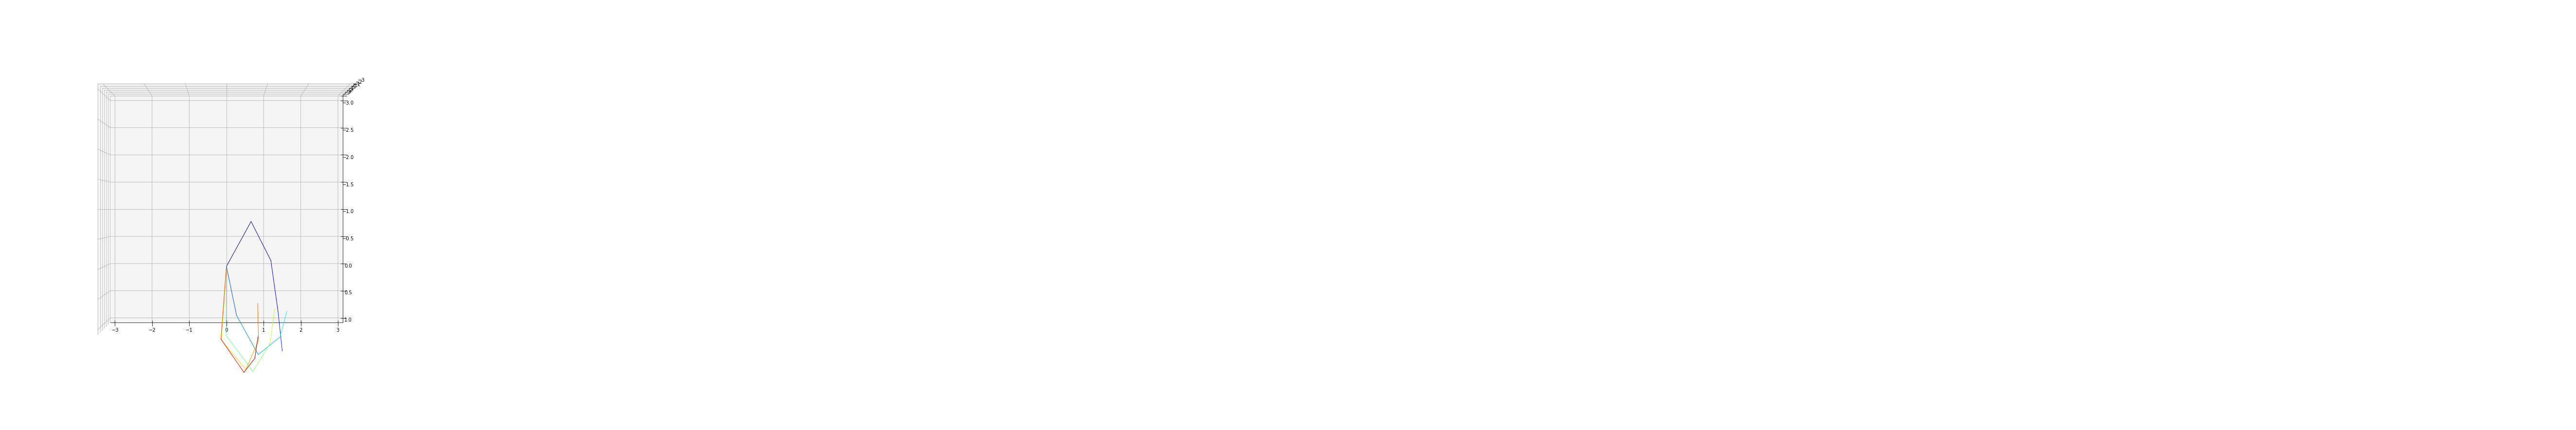

In [16]:
fig = plt.figure(1, figsize=(16, 16))
ax1 = fig.add_subplot(111, projection='3d')
keypoint_coords3d = coords_xyz_rel_normed.detach().numpy()
keypoint_coords3d = keypoint_coords3d.squeeze()
plot_hand_3d(keypoint_coords3d, ax1)
ax1.view_init(azim=-90.0, elev=-90.0)
ax1.set_xlim([-3, 3])
ax1.set_ylim([-3, 1])
ax1.set_zlim([-3, 3])
plt.show()